<a href="https://colab.research.google.com/github/djferranti/RegularizedStokesletsTutorial/blob/main/moments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Discretizing the Sphere
Before we do anything else, we need a discretization of the sphere. There are a few ways to do this, but we choose to do a Spherical Centroidal Voronoi Tesselation (SCVT). We will not go into the details of the algorithm here, but the advantage of this method is the distribution of points is nearly uniform and hence less sensitive to changes in orientation. \* \
(\*see *Using theory and experiments of spheres moving near boundaries to optimize the method of images for regularized Stokeslets* by Nguyen H, *et al.*)

*Spherical Centroid Voronoi Tesselation (SCVT)* \\
Algorithm for generating an approximately uniform distribution of points on a sphere.

In [8]:
import numpy as np
from scipy.spatial import SphericalVoronoi
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
def spherical_triangle_area(a, b, c):
    """
    Compute the area of a spherical triangle on the unit sphere using L'Huilier's formula.
    """
    # Compute the side lengths (arc lengths) on the unit sphere
    a_len = np.arccos(np.clip(np.dot(b, c), -1.0, 1.0))
    b_len = np.arccos(np.clip(np.dot(c, a), -1.0, 1.0))
    c_len = np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

    s = 0.5 * (a_len + b_len + c_len)
    tan_e4 = np.tan(s / 2) * np.tan((s - a_len) / 2) * np.tan((s - b_len) / 2) * np.tan((s - c_len) / 2)
    excess = 4 * np.arctan(np.sqrt(np.abs(tan_e4)))

    return excess  # for unit sphere

def spherical_polygon_area(vertices):
    """
    Compute area of a spherical polygon by dividing into triangles.
    """
    if len(vertices) < 3:
        return 0.0

    area = 0.0
    ref = vertices[0]
    for i in range(1, len(vertices) - 1):
        a = ref
        b = vertices[i]
        c = vertices[i + 1]
        area += spherical_triangle_area(a, b, c)

    return area

def spherical_cvt_with_areas(n_points, n_iters=50, tol=1e-6, radius=1.0, center=np.array([0, 0, 0])):
    """
    Generate a spherical centroidal Voronoi tessellation and return generator points and their areas.

    Parameters
    ----------
    n_points : int
        Number of points on the sphere.
    n_iters : int
        Maximum number of Lloyd iterations.
    tol : float
        Convergence tolerance.
    radius : float
        Radius of the sphere.
    center : ndarray, shape (3,)
        Center of the sphere.

    Returns
    -------
    points : ndarray, shape (n_points, 3)
        Final CVT points on the sphere.
    areas : ndarray, shape (n_points,)
        Area of each Voronoi cell.
    """
    # Start with random points on the sphere
    points = np.random.randn(n_points, 3)
    points /= np.linalg.norm(points, axis=1)[:, np.newaxis]
    points = radius * points + center

    for i in range(n_iters):
        sv = SphericalVoronoi(points, radius=radius, center=center)
        sv.sort_vertices_of_regions()

        new_points = np.zeros_like(points)

        for j, region in enumerate(sv.regions):
            verts = sv.vertices[region]
            centroid = np.mean(verts, axis=0)
            centroid /= np.linalg.norm(centroid)  # Project back to sphere
            new_points[j] = centroid * radius + center

        delta = np.linalg.norm(new_points - points, axis=1).max()
        points = new_points

        if delta < tol:
            break

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = spherical_polygon_area(verts)
        areas.append(area)

    areas = np.array(areas)

    return points, areas

Generate *n_points_sphere* number of points on the unit sphere using the *spherical_cvt* function defined above and then plot with matplotlib.

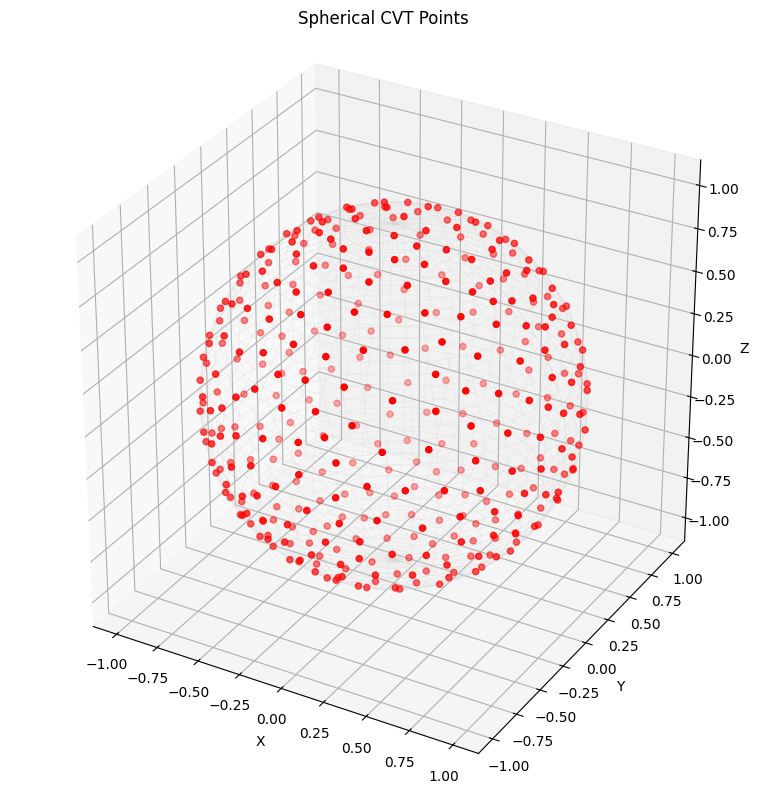

In [9]:
# Assume `points_sphere` is your Nx3 array from spherical_cvt_with_areas
# radius = a = 1
a = 1
n_points_sphere = 400
points_sphere, areas_points_sphere = spherical_cvt_with_areas(n_points=n_points_sphere, n_iters=20, radius = a)

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the unit sphere wireframe for context
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x, y, z, color='lightgray', alpha=0.3, linewidth=0.5)

# Scatter plot of the CVT points
ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2], color='red', s=20)

# Axis properties
ax.set_box_aspect([1, 1, 1])
ax.set_title("Spherical CVT Points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()
plt.show()

#The translating sphere in a Stokes fluid
Assume we have a solid sphere of radius $a$ moving at a constant velocity $\mathbf{U}$ in a fluid. For simplicity, assume the center of the sphere is located at the origin. The fluid velocity $\mathbf{u}$ satisfies

$$ \mathbf{u}(\mathbf{x}) = \frac{a}{4 r}\left (3 + a^2/r^2 \right ) \mathbf U + \frac{3a \left ( \mathbf x \cdot \mathbf U \right )}{4r^2} \left ( 1 - a^2/r^2 \right ) \frac{\mathbf x}{r}, \ \ \ r = | \mathbf x |.$$

The *hydrodynamic traction* (opposite the direction of sphere velocity) on the sphere is $$\mathbf{f} = -\frac{3 \mu}{2a} \mathbf{U}.$$ The total drag $\mathbf{F}_{\text{drag}}$ on the sphere is the integral of the traction over the surface, or $\mathbf{F}_{\text{drag}} = -6 \pi \mu a \mathbf{U} $.

##Plan

Evaluate velocity at several points on an annulus surrounding the sphere ($ a <= r <= R_1$)   using

1.   The 7/2 blob
2.   The 9/2 blob (zero second moment)

Then compare the far-field errors and near-field errors. We expect that the convergence in the far-field is better for the 9/2 blob, but the near-field error convergence should be the same ($\mathcal O(\epsilon)$).

##How?

1. Discretize the sphere using SCVT to return the points/areas of the Voronoi cells.
2. Approximate the velocity by quadrature over the sphere:

$$ \mathbf{u_{\epsilon}}(\mathbf x) = - \iint_{\text{sphere}} \mathcal{S}_{\epsilon}(\mathbf x, \mathbf y) \cdot \mathbf{f}(\mathbf y)  \ dS(\mathbf y) \approx \sum_{i=0}^{\text{n_points_sphere -1}} \mathcal{S}_{\epsilon}(\mathbf x, \mathbf y_i ) \cdot \mathbf f (\mathbf y_i) \ \Delta A_i, \ \ \ A_i = \text{Area of ith Voronoi cell}$$
3. Compare the regularized velocity field to the exact velocity field by evaluating the max of the relative error for all evaluation points in the annulus:

$$ \max_{x \in \text{Annulus}} \left ( \text{relative error} \right )= \max_{x \in \text{Annulus}} \left ( |\mathbf{u}_{\epsilon}(\mathbf x) - \mathbf{u}(\mathbf x)| \right ) / |\mathbf{u}(\mathbf x)| $$

## Coding notes
We write the velocity field due to a force $\mathbf f$ located at $\mathbf y$ as

$$\mathbf{u_{\epsilon}}(\mathbf x) = H_1 \mathbf f + H_2 \left [ \mathbf f \cdot (\mathbf x - \mathbf y) \right ] (\mathbf x - \mathbf y), $$where $H_1$ and $H_2$ are functions of $r = |\mathbf x - \mathbf y |$ which depend on the specific blob function.   

### For the 7/2 blob
$H_1 = \frac{1}{8 \pi} \left ( \frac{1}{(r^2+\epsilon^2)^{1/2}} + \frac{\epsilon^2}{(r^2+\epsilon^2)^{3/2}} \right ), \ \ \ H_2 = \frac{1}{8 \pi  \left (r^2 + \epsilon^2 \right )^{3/2}}$

### For the 9/2 blob
$H_1 = \frac{1}{8 \pi} \left ( \frac{1}{(r^2+\epsilon^2)^{1/2}} + \frac{\epsilon^2}{2(r^2+\epsilon^2)^{3/2}} + \frac{3 \epsilon^4}{2 (r^2 + \epsilon^2)^{5/2}} \right ), \ \ \ H_2 = \frac{1}{8 \pi} \left ( \frac{1}{(r^2 + \epsilon^2)^{3/2}} + \frac{3 \epsilon^2}{2 (r^2 + \epsilon^2)^{5/2} }\right ) $

In [10]:
import numpy as np

def H1_72(r_reg, reg):
    h1 = 1 / (8 * np.pi) * (1 / r_reg + (reg ** 2) / (r_reg ** 3))
    return np.tile(h1[:, np.newaxis], (1, 3))

def H2_72(r_reg, reg):
    h2 = 1 / (8 * np.pi * r_reg ** 3)
    return np.tile(h2[:, np.newaxis], (1, 3))

def H1_92(r_reg, reg):
    h1 = 3 * reg**4 / (16 * np.pi * r_reg**5) + reg**2 / (16 * np.pi * r_reg**3) + 1 / (8 * np.pi * r_reg)
    return np.tile(h1[:, np.newaxis], (1, 3))

def H2_92(r_reg, reg):
    h2 = 1 / (8 * np.pi * r_reg**3) + 3 * reg**2 / (16 * np.pi * r_reg**5)
    return np.tile(h2[:, np.newaxis], (1, 3))

def reg_stokeslet_72(X_eval, X_force, F, reg):
    M = X_eval.shape[0]
    N = X_force.shape[0]

    U = np.zeros((M, 3))

    for j in range(N):
        rvec = X_eval - X_force[j]          # (M, 3)
        r2 = np.sum(rvec**2, axis=1)        # (M,)
        r_reg = np.sqrt(r2 + reg**2)        # (M,) Regularized distance

        h1 = H1_72(r_reg, reg)              # (M, 3)
        h2 = H2_72(r_reg, reg)              # (M, 3)

        Fj = F[j]                           # (3,)
        fdotr = np.sum(rvec * Fj, axis=1)[:, None]  # (M, 1)

        U += h1 * Fj + h2 * fdotr * rvec

    return U

def reg_stokeslet_92(X_eval, X_force, F, reg):
    M = X_eval.shape[0]
    N = X_force.shape[0]

    U = np.zeros((M, 3))

    for j in range(N):
        rvec = X_eval - X_force[j]          # (M, 3)
        r2 = np.sum(rvec**2, axis=1)        # (M,)
        r_reg = np.sqrt(r2 + reg**2)        # (M,) Regularized distance

        h1 = H1_92(r_reg, reg)              # (M, 3)
        h2 = H2_92(r_reg, reg)              # (M, 3)

        Fj = F[j]                           # (3,)
        fdotr = np.sum(rvec * Fj, axis=1)[:, None]  # (M, 1)

        U += h1 * Fj + h2 * fdotr * rvec

    return U


Now get the evaluation points.

In [14]:
#get points in annulus from inner radius R0 to outer raidus R1

#inner and outer radii (R0, R1)
R0 = 1
R1 = 3

#use polar coordinates
n_points_r = 30
n_points_theta = 30
radii = np.linspace(a, R1, n_points_r)
thetas = np.linspace(0, 2*np.pi, n_points_theta, endpoint = False)

#output as a grid in X,Y,Z using outer product
X = np.outer(radii, np.cos(thetas))
Y = np.outer(radii, np.sin(thetas))
Z = np.zeros_like(X)

#get points in disc of radius R1
points_annulus = np.vstack([X.flatten(), Y.flatten(), Z.flatten()]).T
r_annulus = np.sqrt(np.sum(points_annulus * points_annulus, 1) )

Then get the analytical velocity field at the evaluation points.

In [15]:
#viscosity
mu = 1
#components of sphere's translational velocity
u_x = 1
u_y = 0
u_z = 0

#sphere's translational velocity
U_sphere = np.tile([u_x,u_y,u_z], (n_points_sphere, 1))
#force density
F = 3 * mu / (2 * a) * U_sphere * areas_points_sphere[:, np.newaxis]

#exact velocity field
u_x_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a ** 2 / r_annulus**5) * points_annulus[:, 0] ** 2 + a * u_x / (4 * r_annulus) * (3 + a**2 / r_annulus**2)
u_y_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a**2 / r_annulus**5) * points_annulus[:,0] * points_annulus[:,1]
u_z_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a**2 / r_annulus**5) * points_annulus[:,0] * points_annulus[:,2]

U_analytical = np.vstack([u_x_annulus, u_y_annulus, u_z_annulus]).T
U_analytical_norm = np.sqrt(np.sum(U_analytical * U_analytical, axis=1))

Then evaluate the near and far field errors and compare.

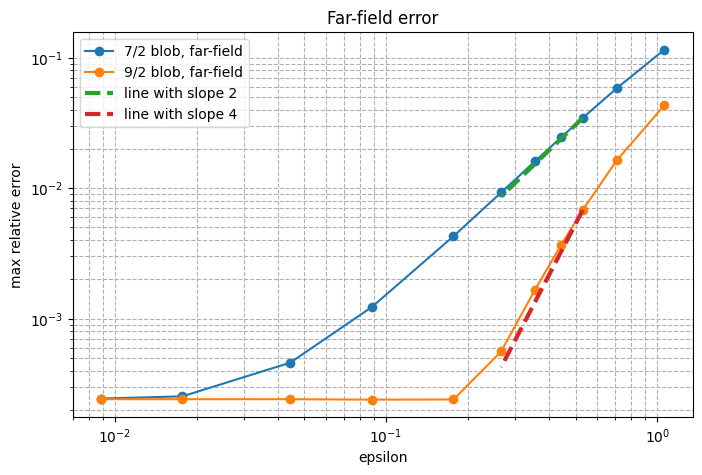

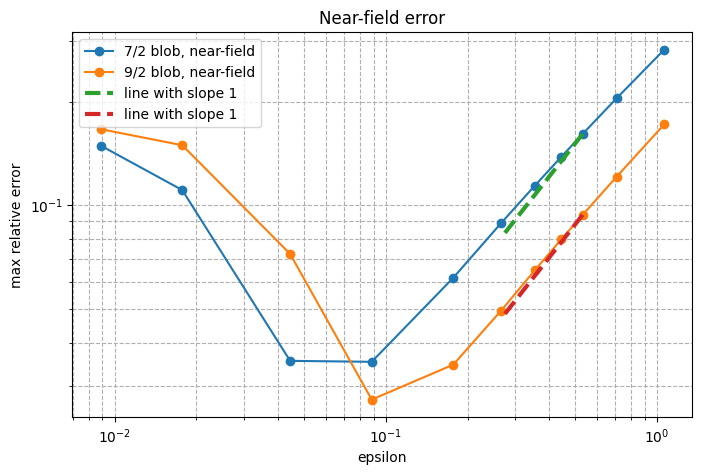

In [24]:
#average spatial discretization length
avg_h = np.sqrt(np.mean(areas_points_sphere))

#regularizations to try
regularizations = avg_h * np.array([6, 4, 3, 5/2, 2, 3/2, 1, 0.5, 0.25, 0.1, 0.05])
max_far_rel_errors_72 = np.zeros_like(regularizations)
max_near_rel_errors_72 = np.zeros_like(regularizations)
max_far_rel_errors_92 = np.zeros_like(regularizations)
max_near_rel_errors_92 = np.zeros_like(regularizations)

for i in range(len(regularizations)):
  reg = regularizations[i]

  #velocity evaluation for 7/2 blob
  U_72 = reg_stokeslet_72(points_annulus, points_sphere, F, reg)
  U_92 = reg_stokeslet_92(points_annulus, points_sphere, F, reg)

  #evaluate errors
  error_72 = (U_72 - U_analytical)
  error_92 = (U_92 - U_analytical)

  #evaluate relative errors for near-field and far-field
  rel_error_72 = np.sqrt(np.sum(error_72 * error_72, axis = 1)) / U_analytical_norm
  near_field_rel_error_72 = rel_error_72[r_annulus < 2 * R0]
  far_field_rel_error_72 = rel_error_72[r_annulus > 2 * R0]

  rel_error_92 = np.sqrt(np.sum(error_92 * error_92, axis = 1)) / U_analytical_norm
  near_field_rel_error_92 = rel_error_92[r_annulus < 2 * R0]
  far_field_rel_error_92 = rel_error_92[r_annulus > 2 * R0]

  #get max relative errors for near and far field
  max_near_rel_errors_72[i] = np.max(near_field_rel_error_72)
  max_far_rel_errors_72[i] = np.max(far_field_rel_error_72)

  max_near_rel_errors_92[i] = np.max(near_field_rel_error_92)
  max_far_rel_errors_92[i] = np.max(far_field_rel_error_92)

plt.figure(figsize=(8, 5))
plt.loglog(regularizations, max_far_rel_errors_72, 'o-', label='7/2 blob, far-field')
plt.loglog(regularizations, max_far_rel_errors_92, 'o-', label='9/2 blob, far-field')

scalebar_x = np.linspace(regularizations[2], regularizations[5],50)
A = max_far_rel_errors_72[2] / regularizations[2] ** 2
scalebar_y = A * scalebar_x ** 2
plt.loglog(scalebar_x, scalebar_y, '--', label= 'line with slope 2', linewidth=3)

scalebar_x = np.linspace(regularizations[2], regularizations[5],50)
A = max_far_rel_errors_92[2] / regularizations[2] ** 4
scalebar_y = A * scalebar_x ** 4
plt.loglog(scalebar_x, scalebar_y, '--', label= 'line with slope 4', linewidth=3)

plt.xlabel('epsilon')
plt.ylabel('max relative error')
plt.title('Far-field error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.loglog(regularizations, max_near_rel_errors_72, 'o-', label='7/2 blob, near-field')
plt.loglog(regularizations, max_near_rel_errors_92, 'o-', label='9/2 blob, near-field')

scalebar_x = np.linspace(regularizations[2], regularizations[5],50)
A = max_near_rel_errors_72[2] / regularizations[2] ** 1
scalebar_y = A * scalebar_x
plt.loglog(scalebar_x, scalebar_y, '--', label= 'line with slope 1', linewidth=3)

scalebar_x = np.linspace(regularizations[2], regularizations[5],50)
A = max_near_rel_errors_92[2] / regularizations[2] ** 1
scalebar_y = A * scalebar_x
plt.loglog(scalebar_x, scalebar_y, '--', label= 'line with slope 1', linewidth=3)

plt.xlabel('epsilon')
plt.ylabel('max relative error')
plt.title('Near-field error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

##And just one more thing...
Specifically in the case of surface forces, it is helpful to have the blob satisfy the "odd moment conditions"

$$\int_0^{\infty} s^{2k+1} \phi_{\epsilon}(s) \ ds = 0, \ \ k \geq 1$$
for some values of $k$. This comes from enforcing

$$\int_{\mathbb{R}^2} (G_{\epsilon}(\mathbf x) - G(\mathbf x)) \ p_n(\mathbf x)  = 0 $$ where $p_n$ is any polynomial of degree $n$\*

See *A convergent boundary integral method for three-dimensional water waves*, Beale and **Using theory and experiments of spheres moving near boundaries to optimize the method of images for regularized Stokeslets* by Nguyen H, *et al.*